# Quantum Swirl
### (Created Useing a Simple Pauli X Rotation Gate)

Import Quantum Blur & IBMQ Backend

In [1]:
import quantumblur as qb
from qiskit import IBMQ, assemble, transpile
from PIL import Image
import numpy as np

provider = IBMQ.load_account()

Create the swirl image

In [2]:
import numpy as np

def make_swirl(Lx,Ly):
    swirl = {}
    for x in range(Lx):
        for y in range(Ly):
            xx, yy = (x-Lx/2), (y-Ly/2)
            d = (xx**2 + yy**2)**0.5
            theta = np.arctan2(yy,xx)
            swirl[x,y] = (1+np.sin(d/10+3*theta))/2
    return swirl

swirl = make_swirl(256,256)

Turn it into a quantum circuit useing the QuantumBlur library.

In [3]:
qc = qb.height2circuit(swirl)

Edit the circuit useing Quiskit and transform it back into an image

In [4]:
def partial_x(qc,fraction):
    for j in range(qc.num_qubits):
        qc.rx(np.pi*fraction,j)

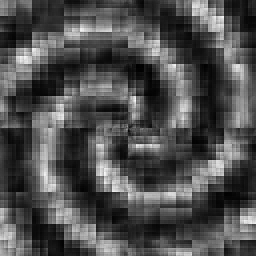

In [5]:
# create the circuit for the original image
qc = qb.height2circuit(swirl)

# do a quarter x rotation of each qubit
partial_x(qc,0.25)

# extract the new height map
rotated_swirl = qb.circuit2height(qc)

# take a look
qb.height2image(rotated_swirl)

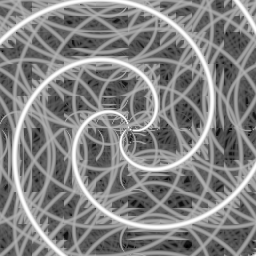

In [6]:
qc = qb.height2circuit(swirl, log=True)

partial_x(qc,0.005)

log_swirl = qb.circuit2height(qc, log=True)

qb.height2image(log_swirl)

Run on Quantum Simulator

In [7]:
def to_image(height_map, size):
    img = np.zeros(size)
    for pixel in height_map:
        x, y = pixel
        img[y][x] = height_map[pixel]
    return img

def to_height_map(img):
    height_map = {}
    for rowNum in range(len(img)):
        row = img[rowNum]
        for pixelNum in range(len(row)):
            pixel = (pixelNum, rowNum)
            height_map[pixel] = img[rowNum][pixelNum]
    return height_map

In [8]:
swirl_height_map = make_swirl(128,128)
swirl = to_image(swirl_height_map, (128,128))
swirl = np.array(Image.fromarray(np.array(swirl)).resize((32, 32), 4))
swirl_height_map = to_height_map(swirl)

qc = qb.height2circuit(swirl_height_map)
partial_x(qc, 0.3)

qc.measure_all()

In [9]:
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(qc, backend=backend)

job = backend.run(transpiled, shots=20000)
retrieved_job = backend.retrieve_job(job.job_id())
counts = job.result().get_counts()

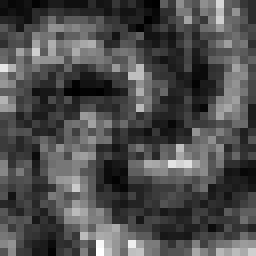

In [10]:
sampled_plus = qb.probs2height(counts)
qb.height2image(sampled_plus).resize((256,256), 4)